In [1]:
import os
import torch
import re
from peft import get_peft_model
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from transformers import AutoTokenizer, AutoModelForCausalLM, AdamW,    TrainingArguments
from datasets import load_dataset
from torch.utils.data.distributed import DistributedSampler
from torch.cuda.amp import GradScaler, autocast
import torch.optim as optim
import wandb
from peft import LoraConfig
from trl import SFTTrainer
from torch.utils.data import DataLoader
import pickle
from glob import glob
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
#from your_module import LoraConfig, get_peft_model  # Ensure you have the correct imports for LoRA

from peft import LoraConfig

#import the bits and bites optimizer again
import bitsandbytes as bnb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#import adamw
from transformers import AdamW
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

In [2]:
def preprocess_data(tokenizer, examples):
    # Tokenize the question to create the model input
    #sentence_to_append = "Please place all of your calculations within the <<Calculations here>>, for example<<48/2=24>>. Inlcude the finsl answer after ####, such as ####NumberAnswer"
    
    #for each row within the examples['question] dataset to each row append sentence to append
    #examples['question'] = [x + sentence_to_append for x in examples['question']]

    model_inputs = tokenizer(examples['question'], truncation=True, padding='max_length', max_length=64)
    
    # Tokenize the answer to create the labels
    # The labels should be the input_ids from the tokenized answer
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['answer'], truncation=True, padding='max_length', max_length=64)
    
    model_inputs['labels'] = labels['input_ids']
    return model_inputs


In [5]:
!ls

GPT2_fine_tune.py			 gpu_parallel_training_starter.py
GPT2_fine_tune_evaluate.py		 llama7b_lora_fine_tune.py
GPT2_training_llms_on_activations.ipynb  llama7b_lora_fine_tune_evaluate.py
analyze_gradients.ipynb			 llama7b_lora_fine_tune_stable.py
archive					 llama7b_partv8.py
dense_activations.pkl			 llm_checking_model_output.ipynb


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [3]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
#model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")

tokenizer.pad_token = tokenizer.eos_token

##############TRAIN###############
# Correct dataset configuration and preprocessing
data = load_dataset("gsm8k", "main", split='train')
data = data.map(lambda e: preprocess_data(tokenizer, e), batched=True)
##############TRAIN###############

##############VALIDATION###############
data_v_string = load_dataset("gsm8k", "main", split='test')
data_v = data_v_string.map(lambda e: preprocess_data(tokenizer, e), batched=True)
##############VALIDATION###############

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1319 [00:00<?, ? examples/s]

## Loading in the Sparse Model

In [6]:
# Initialize a model with the same configuration as the one you trained
sparse_model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")
sparse_model_state_dict = torch.load('../sparse_model_checkpoint_epoch_1.pth')
sparse_model.load_state_dict(sparse_model_state_dict)

<All keys matched successfully>

## Loading in the Dense Model

In [7]:
# Initialize a model with the same configuration as the one you trained
dense_model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")
dense_model_state_dict = torch.load('../dense_model_checkpoint_epoch_1.pth')
dense_model.load_state_dict(dense_model_state_dict)

<All keys matched successfully>

In [8]:
# Set the device to GPU if available, otherwise CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#NOw generate the the activations only for the dense model, and save them to local
def generate_activations(model, input_ids, batch_size=8):
    activations = []
    model.to(device)  # Ensure the model is on the correct device
    for i in range(0, len(input_ids), batch_size):
        batch_input_ids = input_ids[i:i+batch_size].to(device)  # Get batch of inputs
        with torch.no_grad():  # Disable gradient calculation
            logits = model(batch_input_ids).logits
        activations.append(logits.view(logits.size(0), -1).cpu().numpy())  # Move to CPU before converting to numpy
    return np.concatenate(activations, axis=0)
    #return logits

In [16]:
#only taking in the input ids
input_ids = torch.tensor(data['input_ids']).to(device)

## Loading in the data

In [17]:

dense_activations = generate_activations(dense_model, input_ids)
sparse_activations = generate_activations(sparse_model, input_ids)


In [18]:

#Combine activations and create labels
X = np.vstack((dense_activations, sparse_activations))
y = np.array([1] * len(dense_activations) + [0] * len(sparse_activations))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [19]:
len(dense_activations)

1000

In [20]:
sparse_activations

array([[-27.876312  , -28.064793  , -29.150726  , ...,   8.961746  ,
         10.122524  ,  23.649586  ],
       [-32.126354  , -32.226894  , -33.262794  , ...,  18.993763  ,
         20.683235  ,  33.696075  ],
       [-28.466015  , -28.507162  , -30.405523  , ..., -18.710066  ,
        -18.124687  ,  -3.1661482 ],
       ...,
       [-32.2189    , -31.996208  , -34.115276  , ..., -28.02538   ,
        -26.850119  , -10.790979  ],
       [-30.537884  , -30.38633   , -31.228456  , ..., -25.525091  ,
        -24.897264  ,  -9.473276  ],
       [-29.618498  , -29.859652  , -31.344059  , ...,  -0.22788148,
         -2.6674404 ,  15.093011  ]], dtype=float32)

Accuracy: 0.9925
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       201
           1       0.99      1.00      0.99       199

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



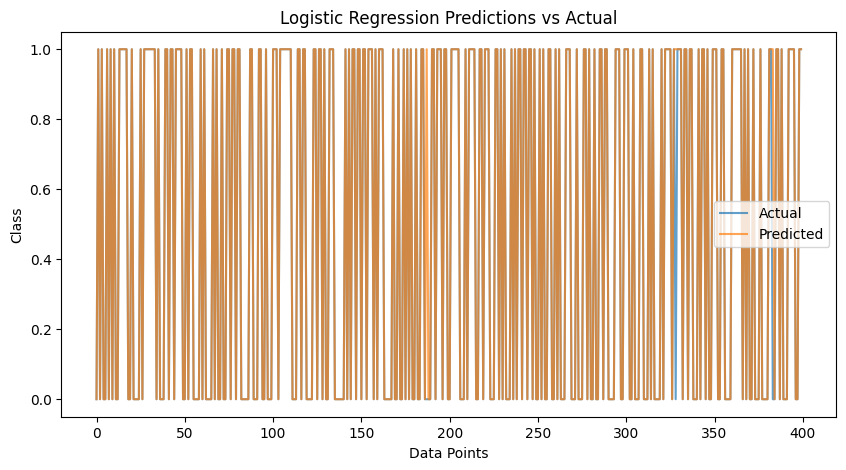

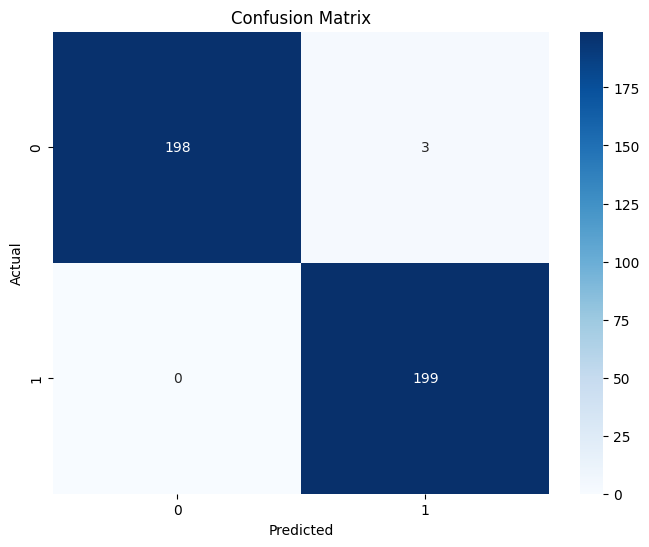

In [21]:




# Predict the labels for the test set
y_pred = lr_model.predict(X_test)
#create random 0s and 1s in y_pred
#y_pred = np.random.randint(0, 2, size=y_test.shape)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Generate classification report
report = classification_report(y_test, y_pred)
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the predicted labels vs. the actual labels
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Data Points')
plt.ylabel('Class')
plt.title('Logistic Regression Predictions vs Actual')
plt.legend()
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [22]:
#The end